In [1]:
#load conda environment effID

import os

import argparse
import torch
import os
import glob
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms as T
from torchvision.transforms import Resize
from torch.utils.data import DataLoader, Dataset
import torchvision
from tqdm import tqdm

import torch.nn.functional as Func

import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--data_path', type=str, default="/usr/users/vogg/Labelling/Lemurs/labelling_app_indID/experiments/")
parser.add_argument('--output_path', type=str, default="models/id/")
parser.add_argument('--experiment', type=str, default="cluster_1000_5000")
parser.add_argument('--group', type=str, default="R1")
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--num_epochs', type=int, default=100)
parser.add_argument('--gpus', type=int, nargs='+', default=[0])
args,unknown = parser.parse_known_args()

In [ ]:
class IDDataset(Dataset):
    def __init__(self, root_path, txt_filename='cluster_1000_5000_R1.txt', train=True, test_size=0.2, unknown_prop = 1, random_state=64):
        self.root_path = root_path
        self.image_dir = os.path.join(root_path, "images")
        self.txt_path = os.path.join(root_path, txt_filename)

        # Read label file
        df = pd.read_csv(self.txt_path, header=None,
                         names=["filename", "x", "y", "w", "h", "id", "score"])

        # Extract experiment name for splitting (e.g. "R_e1_c1" from "R_e1_c1_31257.png")
        df["experiment"] = df["filename"].apply(lambda x: "_".join(x.split("_")[:-1]))

        if 0 < unknown_prop < 1:
            max_id = df["id"].max()
            max_id_rows = df[df["id"] == max_id]
            sampled_max_id_rows = max_id_rows.sample(frac=unknown_prop, random_state=random_state)
            df = pd.concat([df[df["id"] != max_id], sampled_max_id_rows]).reset_index(drop=True)

        # Split by experiment
        experiments = df["experiment"].unique()
        train_exps, test_exps = train_test_split(
            experiments, test_size=test_size, random_state=random_state)

        if train:
            self.df = df[df["experiment"].isin(train_exps)].reset_index(drop=True)
        else:
            self.df = df[df["experiment"].isin(test_exps)].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["filename"])
        image = Image.open(img_path).convert("RGB")


        x, y, w, h = int(row["x"]), int(row["y"]), int(row["w"]), int(row["h"])
        bbox = torch.tensor([int(x - w/2), int(y - h/2), int(x + w/2), int(y + h/2)])
        image_tensor = T.ToTensor()(image).unsqueeze(0)
        cropped = self.crop_and_pad(image=image_tensor, bbox=bbox, output_size=(224, 224)).squeeze(0)


        label = int(row["id"])
        return cropped, label




    def crop_and_pad(self, image, bbox, output_size=(224, 224)):
        x1, y1, x2, y2 = [max(0, val) for val in bbox.squeeze().int().tolist()]
        
        cropped = image[:, :, y1:y2, x1:x2] 

        h, w = cropped.shape[2:]

        # Determine padding to make it square
        if h > w:
            padding = (h - w) // 2
            padding_dims = (padding, h - w - padding, 0, 0)  # Pad left/right equally, no padding for top/bottom
        else:
            padding = (w - h) // 2
            padding_dims = (0, 0, padding, w - h - padding)  # Pad top/bottom equally, no padding for left/right

        padded_square = Func.pad(cropped, padding_dims, value=0)

        resize_transform = Resize(output_size)
        resized = resize_transform(padded_square)

        return resized

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if args.gpus[0] >= 0 else 'cpu')

print('Setting up data...')

data_path = os.path.join(args.data_path, args.experiment, args.group)

transform = T.Compose([
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dset_val = IDDataset(data_path, args.experiment + "_" + args.group + ".txt", train=False, transform=transform, test_size=0.2, unknown_prop=1, random_state=64)
print("datasets loaded")


Setting up data...
datasets loaded


In [6]:
num_classes = max(dset_val.df['id']) + 1

model = torchvision.models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
checkpoint_files = os.listdir(os.path.join("..", args.output_path, args.group, args.experiment))

numbers = set()
for file in checkpoint_files:
    if file.endswith('.pth'):
        numbers.add(int(file.split("_")[-1].replace(".pth", "")))
max_number = max(numbers) if numbers else None
print(max_number)
if max_number is not None and max_number > 10:
    checkpoint_path = os.path.join("..", args.output_path, args.group, args.experiment, f"model_checkpoint_{max_number-10}.pth")
    state_dict = torch.load(checkpoint_path, map_location=device)
    #remove prefix "cnn." from each key
    state_dict = {k.replace("cnn.", ""): v for k, v in state_dict.items()}
    model.load_state_dict(state_dict)
model.to(device);

/user/vogg/miniconda3/envs/effID/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/user/vogg/miniconda3/envs/effID/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


14


/tmp/ipykernel_2661892/1397823514.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path, map_location=device)


/user/vogg/miniconda3/envs/effID/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Class Balanced Accuracy (without unknown class): 80.40%
Validation Accuracy without unknown class: 79.04%
Class Balanced Accuracy (with unknown class): 73.11%
Validation Accuracy with unknown class: 71.54%


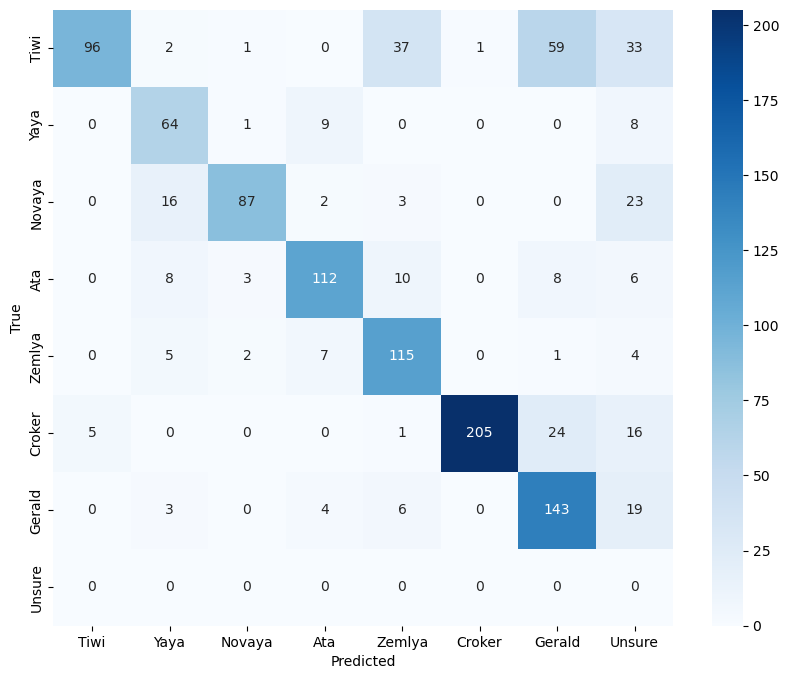

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt


seed = 2
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)



val_loader = DataLoader(dset_val, batch_size=args.batch_size, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=4)


# Depending on args.group, add the indiivdual names ['Tiwi', 'Yaya', 'Novaya', 'Ata', 'Zemlya', 'Croker', 'Gerald', 'Unsure', 'Uns'] if group==R1
if args.group == 'R1':
    individual_names = ['Tiwi', 'Yaya', 'Novaya', 'Ata', 'Zemlya', 'Croker', 'Gerald', 'Unsure']
elif args.group == 'Alpha':
    individual_names = ['Floreana', 'Rabita', 'Genovesa', 'Redonda', 'George', 'Hermanos', 'Chatam', 'Pinta', 'Marchena', 'Darwin', 'Nissan', 'UnmarkedMale', 'Unsure']
elif args.group == 'B':
    individual_names = ['Haruko', 'Isabella', 'Saparua', 'Kai', 'Bacan', 'Lugus', 'Ambon', 'Pata', 'Dammai', 'Unsure']
elif args.group == 'J':
    individual_names = ['Cambodia', 'Beirut', 'Palestina', 'Taji', 'Myanmar', 'Agypten', 'Golan', 'Chennai', 'Unsure']
else:
    individual_names = []

all_preds = []
all_labels = []
max_label = max(dset_val.df['id'])
model.eval()

for val_inputs, val_labels in tqdm(val_loader, desc="Validation", leave=False):
    # remove all those val_labels that have the highest label (unknown class)

    mask = val_labels < max_label
    val_inputs = val_inputs[mask]
    val_labels = val_labels[mask]

    val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

    with torch.no_grad():
        val_outputs = model(val_inputs)
        _, val_predicted = val_outputs.max(1)
        all_preds.extend(val_predicted.cpu().numpy())
        all_labels.extend(val_labels.cpu().numpy())


# The highest value is the unknown class. I would like to ignore it in the accuracy calculation.
filtered_preds = [pred for pred, label in zip(all_preds, all_labels) if pred < max_label]
filtered_labels = [label for pred, label in zip(all_preds, all_labels) if pred < max_label]

accuracy = np.mean(np.array(filtered_preds) == np.array(filtered_labels))
balanced_acc = balanced_accuracy_score(filtered_labels, filtered_preds)
print(f'Class Balanced Accuracy (without unknown class): {balanced_acc * 100:.2f}%')
print(f'Validation Accuracy without unknown class: {accuracy * 100:.2f}%')
accuracy_with_unknown = np.mean(np.array(all_preds) == np.array(all_labels))
balanced_acc_with_unknown = balanced_accuracy_score(all_labels, all_preds)
print(f'Class Balanced Accuracy (with unknown class): {balanced_acc_with_unknown * 100:.2f}%')
print(f'Validation Accuracy with unknown class: {accuracy_with_unknown * 100:.2f}%')



cm = confusion_matrix(all_labels, all_preds, labels=list(range(num_classes)))
#add individual names to the confusion matrix if available
if individual_names:
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=individual_names, yticklabels=individual_names)
    plt.xlabel('Predicted') 
    plt.ylabel('True')
    plt.show()
else:
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted') 
    plt.ylabel('True')
    plt.show()

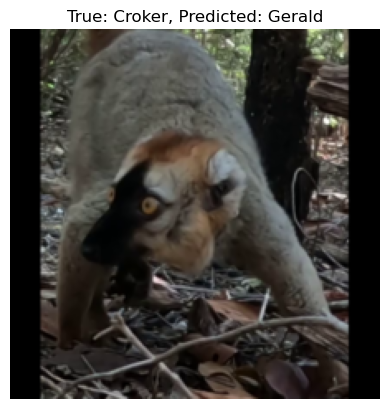

In [28]:
# Visualize a misprediction
misclassified_indices = [i for i, (pred, label) in enumerate(zip(all_preds, all_labels)) if (pred != label) and (pred < max_label)]
if misclassified_indices:
    idx = random.choice(misclassified_indices)
    img, true_label = dset_val[idx]
    pred_label = all_preds[idx]

    # Convert tensor to numpy array for visualization
    img_np = img.permute(1, 2, 0).numpy()
    #img_np = (img_np * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406])  # Unnormalize
    img_np = np.clip(img_np, 0, 1)

    plt.imshow(img_np)
    plt.title(f'True: {individual_names[true_label]}, Predicted: {individual_names[pred_label]}')
    plt.axis('off')
    plt.show()

(1, 512, 7, 7)


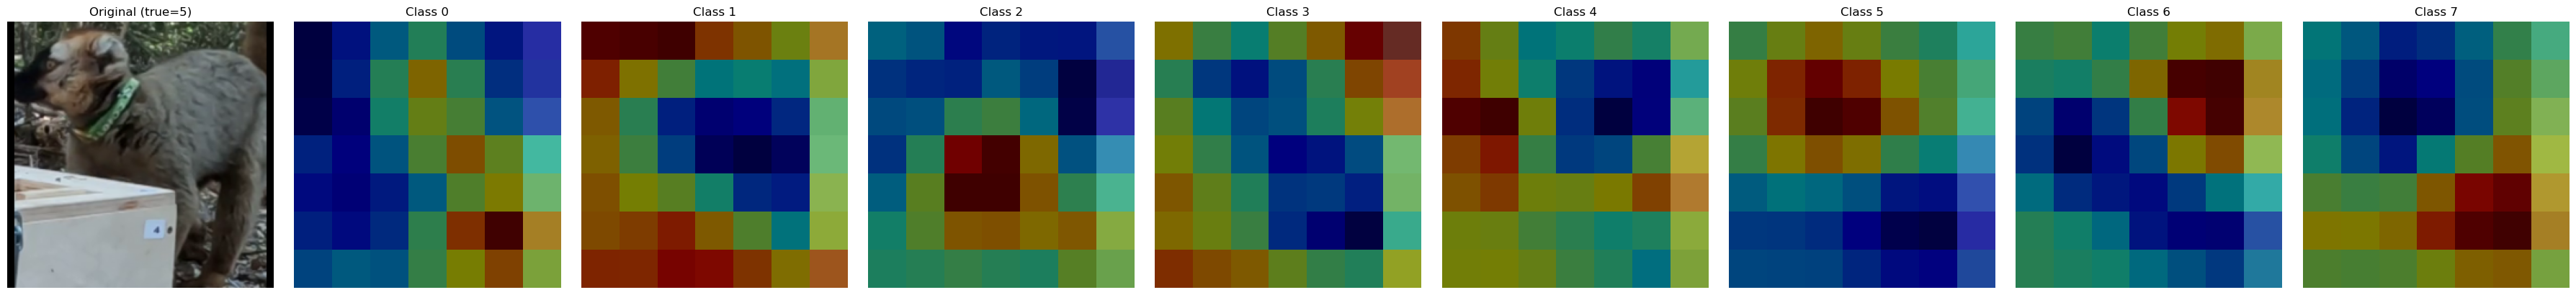

In [ ]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np



# Assuming you already defined model, num_classes, val_loader, etc.

# Hook for the feature maps
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.detach().cpu().numpy())

# Register hook on last conv layer of ResNet-18
finalconv_name = 'layer4'
model._modules.get(finalconv_name).register_forward_hook(hook_feature)

# Get the weights of the final fully connected layer
params = list(model.parameters())
weight_softmax = model.fc.weight.detach().cpu().numpy()  # shape: [num_classes, 512]

# Function to compute CAM
def generate_cam(feature_conv, weight_softmax, class_idx):
    # feature_conv: [batch, 512, H, W]
    nc, h, w = feature_conv.shape
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    #cam = cam - np.min(cam)
    #cam = cam / np.max(cam)
    return cam


idx = 
# Take one batch from val_loader
image, label = dset_val[idx]


# Forward pass
model.eval()
with torch.no_grad():
    output = model(image.unsqueeze(0).cuda() if next(model.parameters()).is_cuda else image)

# Extract the feature maps
feature_conv = features_blobs[0]  # shape: [1, 512, H, W]
print(feature_conv.shape)

# Plot CAMs for all classes
fig, axs = plt.subplots(1, num_classes+1, figsize=(4*(num_classes+1), 4))

# Show original image first
img_np = image.permute(1, 2, 0).numpy()
axs[0].imshow(img_np)
axs[0].set_title(f"Original (true={label})")
axs[0].axis('off')

# CAMs for each class
for cls in range(num_classes):
    cam = generate_cam(feature_conv[0], weight_softmax, cls)
    axs[cls+1].imshow(img_np)
    axs[cls+1].imshow(cam, cmap='jet', alpha=0.5)
    axs[cls+1].set_title(f"Class {cls}")
    axs[cls+1].axis('off')

plt.tight_layout()
plt.show()




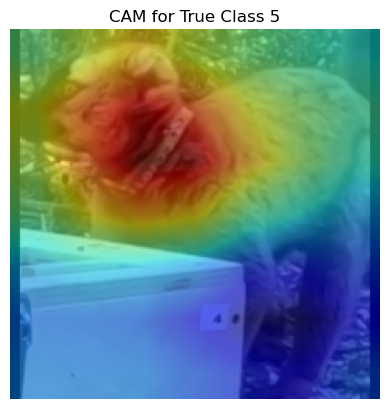

In [21]:


cls = label
cam = generate_cam(feature_conv[0], weight_softmax, cls) 
plt.imshow(img_np)
# Rescale CAM to match image size if needed
import torch.nn.functional as F

if cam.shape != img_np.shape[:2]:
    cam_tensor = torch.from_numpy(cam).unsqueeze(0).unsqueeze(0).float()
    cam_resized = F.interpolate(cam_tensor, size=img_np.shape[:2], mode='bilinear') #'nearest' for original heatmap
    cam_resized = cam_resized.squeeze().numpy()
else:
    cam_resized = cam

plt.imshow(cam_resized, cmap='jet', alpha=0.5)
plt.title(f"CAM for True Class {cls}")
plt.axis('off')
plt.show()